---

---

# **Emotion Recognition from Speech using Mel Spectrograms and CNNs**

You can find all the details of the methods used in this notebook in the `REPORT.md` file on my [GitHub repository](https://github.com/SigurdST/emotion_recognition).

---

---

# 1 - ***Data preparation***

### Import the data
We use `librosa`, a package specialized in audio analysis.

In [1114]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [1115]:
import torch

device = torch.device("mps")  # Définit le GPU MPS comme appareil

In [1116]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/d07 (3).wav,44100,3.032562


In [1117]:
df_metadata.shape

(605, 4)

---

## 1.A - **Data exploration**

### Waveform of the first file

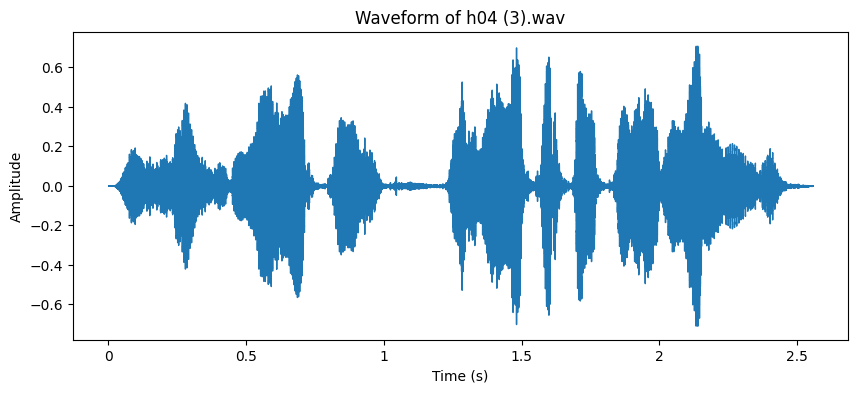

In [1118]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Adding an *emotion* column

In [1119]:
# Extract emotion labels from file names (the first letter of the file name indicates emotion)
df_metadata['emotion'] = df_metadata['file_name'].str[0]

# Map single-letter codes to emotion names
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

### Example of waveform for every emotion

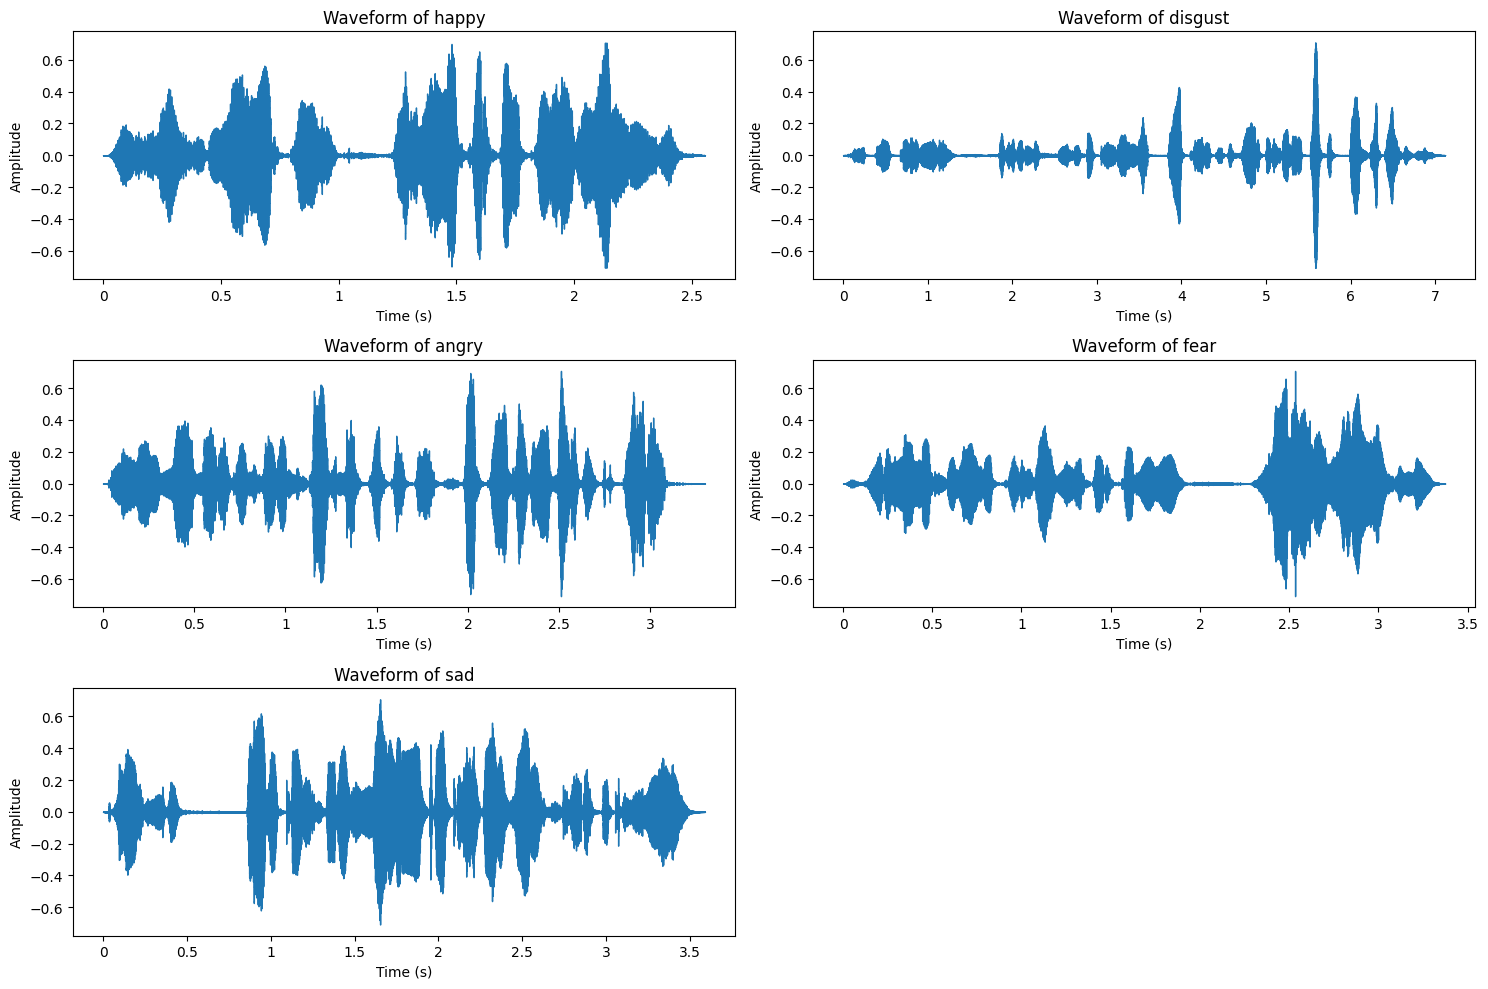

In [1120]:
# Obtaining the unique emotions
emotions = df_metadata['emotion'].unique()
files_per_emotion = {}

# Select one file per emotion
for emotion in emotions:
    files_per_emotion[emotion] = df_metadata[df_metadata['emotion'] == emotion].iloc[0]['file_path']

# Create a figure to plot the waveforms
plt.figure(figsize=(15, 10))

for i, (emotion, file_path) in enumerate(files_per_emotion.items(), 1):
    y, sr = librosa.load(file_path, sr=None)
    plt.subplot(3, 2, i) 
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Histogram of audio durations

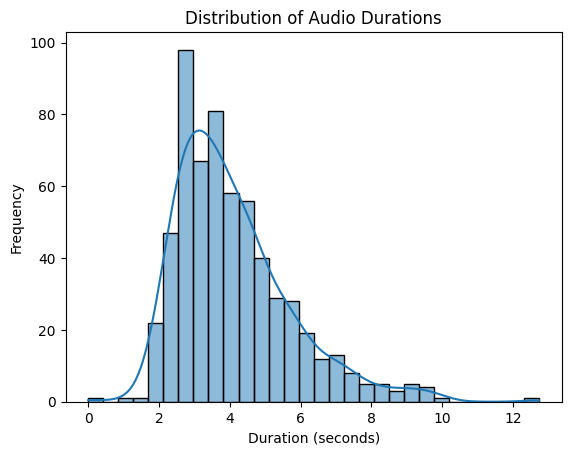

In [1121]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

We observe that there is an audio with a duration of 0 second, we remove it

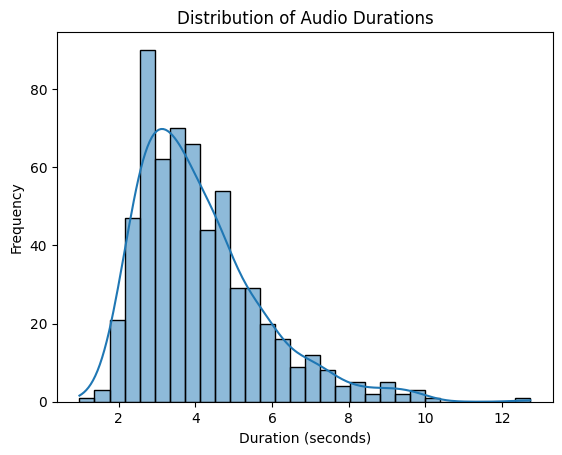

In [1122]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

### Duration of the audio files by emotion
Table :

In [1123]:
# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()
emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,122.0,4.591546,2.049071,2.035828,3.174796,4.078628,4.986196,12.734853


Histograms :

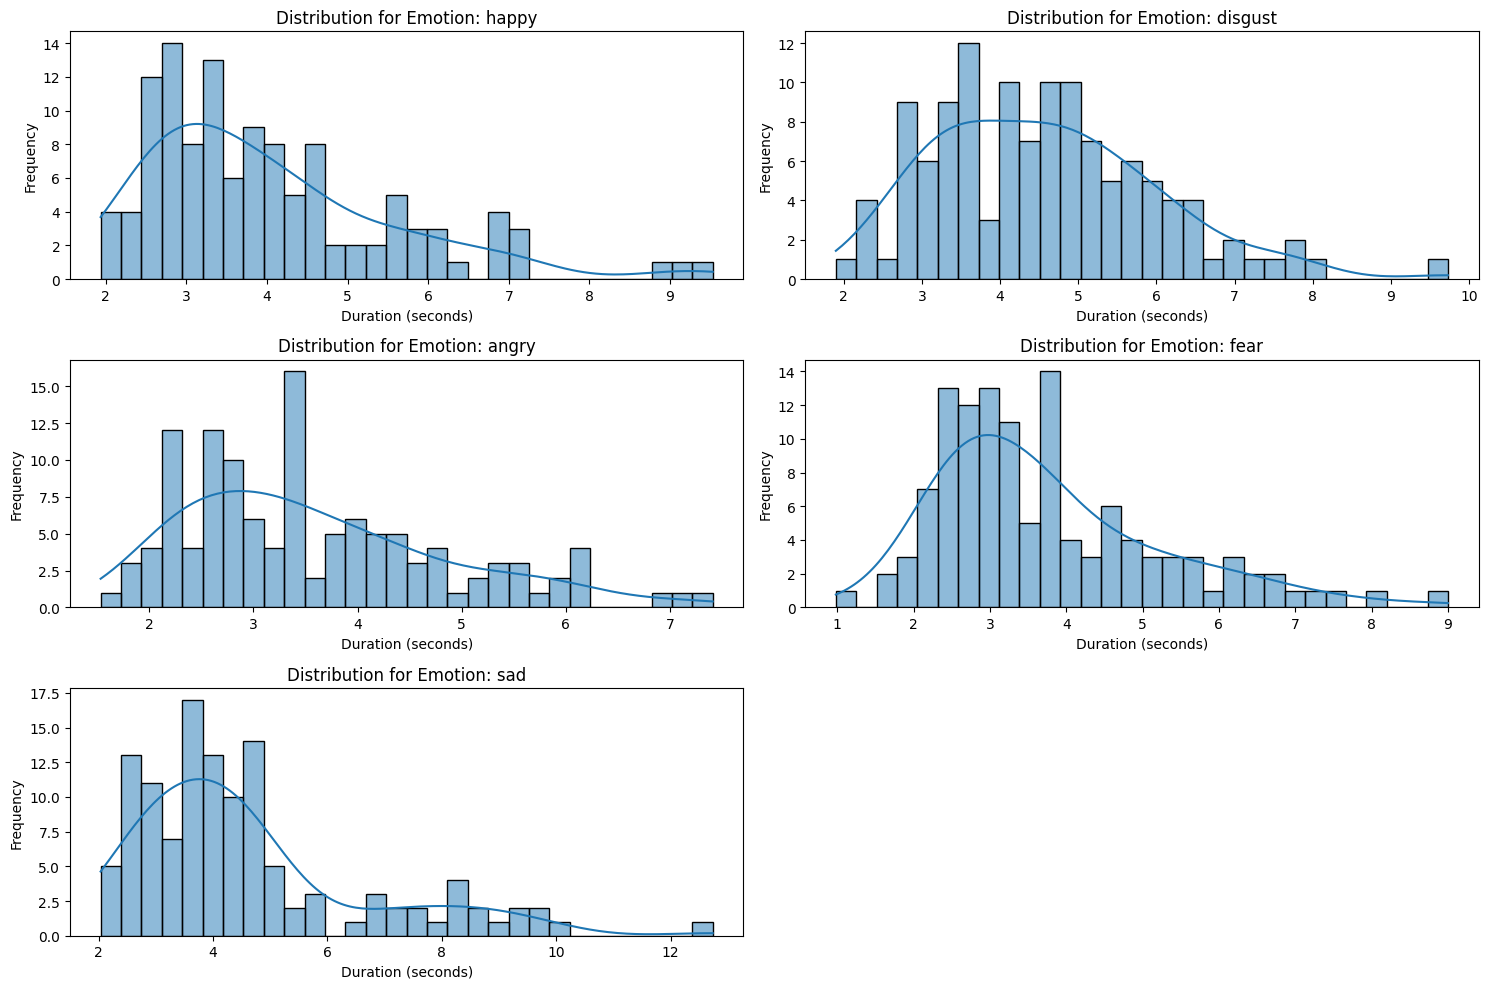

In [1124]:
categories = df_metadata['emotion'].unique()

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, 1):
    plt.subplot(3, 2, i)
    sns.histplot(
        df_metadata[df_metadata['emotion'] == category]['duration_sec'],
        bins=30,
        kde=True
    )
    plt.title(f"Distribution for Emotion: {category}")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

We cannot observe important variation of duration according to emotion.

---

## 1.B - **Data processing**

### Noise Reduction

We reduce noise using the `noisereduce` package.

In [1125]:
import librosa.display
import noisereduce as nr


# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=None):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    noise_profile = y[:int(sr * 1)]

# Reduce noise
    y = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

### Mel spectogram
Mel spectrograms transform audio files into numeric representations using the Discrete Fourier Transform.

In [1126]:
import numpy as np

# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Function to visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

We create a column to store the mel spectrogram, and plot an example of a mel spectrogram for the first file.

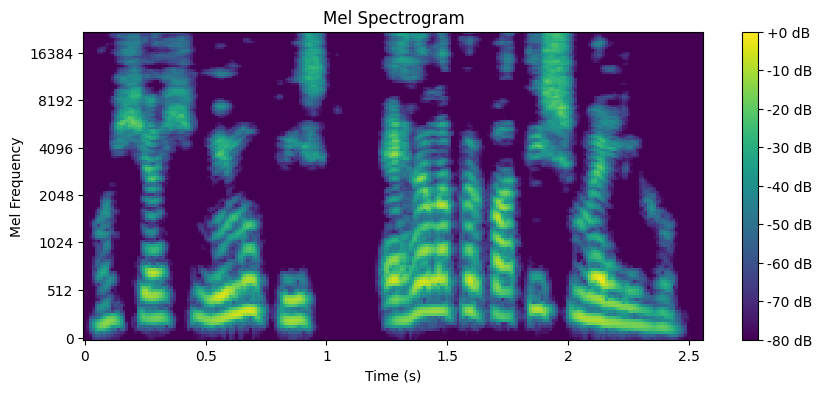

In [1127]:
# We add a new column to store the Mel Spectrogram data
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
                
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Visualize the spectrogram for the first file
        if index == 0:
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

We export all the Mel spectrograms plots and save them in the folder *processed_spectrogram* (avalaible on [GitHub](https://github.com/SigurdST/emotion_recognition)).

In [1128]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })

output_dir = "plot_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()

### Mean decibel values in the spectrograms for every emotion

In [1129]:
mean_sum_db = 0
for spec in df_metadata['mel_spectrogram']:
    mean_sum_db += np.sum(spec)/spec.shape[1]
mean_sum_db /= len(df_metadata['mel_spectrogram'])
print(f"Mean sum of dB values: {mean_sum_db}")

mean_sum_db_by_emotion = {}

for emotion in df_metadata['emotion'].unique():

    specs = df_metadata[df_metadata['emotion'] == emotion]['mel_spectrogram']on
    total_sum_db = 0

    for spec in specs:
        total_sum_db += np.sum(spec) / spec.shape[1]

    mean_sum_db_by_emotion[emotion] = total_sum_db / len(specs)

for emotion, mean_sum in mean_sum_db_by_emotion.items():
    print(f"Emotion: {emotion}, mean sum of dB values: {mean_sum}")

Mean sum of dB values: -8450.106890589786
Emotion: happy, mean sum of dB values: -8413.536775910055
Emotion: disgust, mean sum of dB values: -8554.73667156356
Emotion: angry, mean sum of dB values: -8281.237260056003
Emotion: fear, mean sum of dB values: -8387.866761152081
Emotion: sad, mean sum of dB values: -8609.853211861911


We do not observe a significant difference in the means.

---

---

# 2 - ***Convolutional Neural Network***
### Data preparation to modelisation
We prepare the data for the neural network by labeling the target variable and creating training and test sets.

In [1130]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode emotions
label_encoder = LabelEncoder()
df_metadata['emotion_encoded'] = label_encoder.fit_transform(df_metadata['emotion'])

# Split the data
train_df, test_df = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata['emotion_encoded'], random_state=42)

# Display the mapping between labels and emotions
emotion_label_mapping = {label: emotion for label, emotion in enumerate(label_encoder.classes_)}
print("Mapping between labels and emotions:", emotion_label_mapping)

Mapping between labels and emotions: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad'}


We create custom `PyTorch` Dataset class that wraps a DataFrame containing Mel spectrograms and their corresponding labels.

In [1131]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Class to convert the DataFrame to a PyTorch Dataset with tensors
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']

        # Normalize the spectrogram
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Convert the NumPy array to PyTorch tensors
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor


# Create the datasets
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)

### Functions to train and evaluate our CNNs

In [1132]:
# Function to train the model
def train_model(model, train_loader, test_loader, learning_rate, num_epochs, device=device):
    # Move the model to the specified device
    model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    # Variables to store the best model
    best_test_accuracy = 0.0  # Initialize with the lowest possible accuracy
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        
        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation
            for inputs, targets in test_loader:
                # Move inputs and targets to the specified device
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute test loss
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                # Compute predictions
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Compute average test loss
        average_test_loss = test_loss / len(test_loader)
        test_losses.append(average_test_loss)

        # Calculate test accuracy
        test_accuracy = 100 * correct / total

        # Save the model if this is the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state = model.state_dict()  # Save model parameters
            best_epoch = epoch + 1
            torch.save(best_model_state, "best_model.pth")  # Save best model to disk

        # Display metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}")
            print(f"Test Loss after Epoch {epoch+1}: {average_test_loss:.4f}")
            print(f"Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%")
            print("-" * 50)

    return train_losses, test_losses, {"Best epoch": best_epoch, "Best test accuracy": best_test_accuracy}


# Function to plot the loss curve
def plot_loss_curves(train_losses, test_losses):

    if train_losses and test_losses:
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()



# Function to evaluate the model
def evaluate_model(model, test_loader, device=device):

    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy after moving them to the CPU
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)

    # Print metrics
    print("-" * 50)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print("-" * 50)

The fist issue is that all the spectrograms don't have the same size. To adapt to this, we try two methods :
- CNNs with batch size of 1
- CNNs with resized data

We will then compare which method is better.

The second issue is that we have a small dataset (604 audio files). To adapt to this we will try to increase the size of our dataset.

---

## 2.A - **CNNs with batch of size 1**

### 2.A.1 - *3 Layers*

In [1133]:
# Create the data loaders with a batch size of 1
train_loader_bs1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

# CNN model with 3 layers
class EmotionCNN3layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Number of classes
num_classes = len(label_encoder.classes_)

### Train with learning rate = 0.01

In [1134]:
model_bs1_3lay1 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_3lay1, train_loader_bs1, test_loader_bs1, 0.01, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 1.6178
Test Loss after Epoch 5: 1.6101
Test Accuracy after Epoch 5: 19.83%
--------------------------------------------------
Epoch 10/50, Training Loss: 1.6178
Test Loss after Epoch 10: 1.6103
Test Accuracy after Epoch 10: 19.83%
--------------------------------------------------
Epoch 15/50, Training Loss: 1.6153
Test Loss after Epoch 15: 1.6131
Test Accuracy after Epoch 15: 20.66%
--------------------------------------------------
Epoch 20/50, Training Loss: 1.6170
Test Loss after Epoch 20: 1.6120
Test Accuracy after Epoch 20: 19.83%
--------------------------------------------------
Epoch 25/50, Training Loss: 1.6172
Test Loss after Epoch 25: 1.6105
Test Accuracy after Epoch 25: 19.83%
--------------------------------------------------
Epoch 30/50, Training Loss: 1.6164
Test Loss after Epoch 30: 1.6110
Test Accuracy after Epoch 30: 19.83%
--------------------------------------------------
Epoch 35/50, Training Loss: 1.6177
Test Loss after Epoch 35: 1.6100

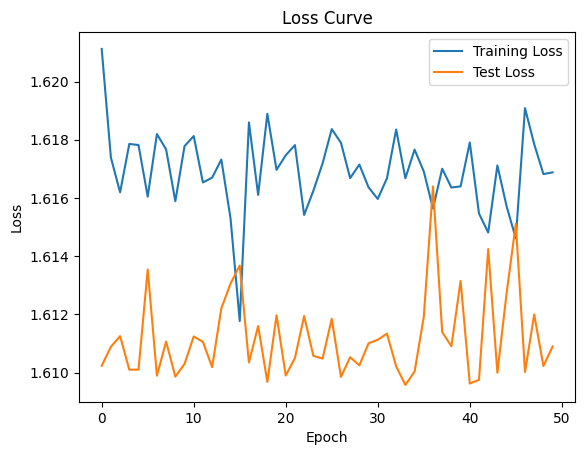

--------------------------------------------------
Test Accuracy: 20.66%
--------------------------------------------------


In [1135]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_3lay1 = EmotionCNN3layBS1(num_classes=num_classes)
best_model_bs1_3lay1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_3lay1, test_loader_bs1, device=device)

The loss does not converge when the learning rate is set to 0.01.

### Train with learning rate = 0.001

In [1136]:
model_bs1_3lay2 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_3lay2, train_loader_bs1, test_loader_bs1, 0.001, 300)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/300, Training Loss: 1.5961
Test Loss after Epoch 5: 1.5716
Test Accuracy after Epoch 5: 27.27%
--------------------------------------------------
Epoch 10/300, Training Loss: 1.4595
Test Loss after Epoch 10: 1.4624
Test Accuracy after Epoch 10: 35.54%
--------------------------------------------------
Epoch 15/300, Training Loss: 1.3231
Test Loss after Epoch 15: 1.3953
Test Accuracy after Epoch 15: 42.98%
--------------------------------------------------
Epoch 20/300, Training Loss: 1.2667
Test Loss after Epoch 20: 1.3209
Test Accuracy after Epoch 20: 42.15%
--------------------------------------------------
Epoch 25/300, Training Loss: 1.1897
Test Loss after Epoch 25: 1.2575
Test Accuracy after Epoch 25: 54.55%
--------------------------------------------------
Epoch 30/300, Training Loss: 1.0941
Test Loss after Epoch 30: 1.1990
Test Accuracy after Epoch 30: 48.76%
--------------------------------------------------
Epoch 35/300, Training Loss: 1.0690
Test Loss after Epoch 35:

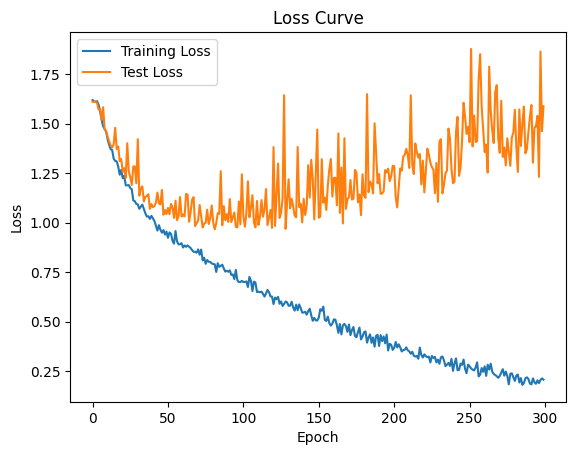

--------------------------------------------------
Test Accuracy: 74.38%
--------------------------------------------------


In [1137]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_3lay2 = EmotionCNN3layBS1(num_classes=num_classes)
best_model_bs1_3lay2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_3lay2, test_loader_bs1, device=device)

### Train with learning rate = 0.0001

In [1184]:
model_bs1_3lay3 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_3lay3, train_loader_bs1, test_loader_bs1, 0.0001, 1000)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/1000, Training Loss: 1.6087
Test Loss after Epoch 5: 1.6029
Test Accuracy after Epoch 5: 20.66%
--------------------------------------------------
Epoch 10/1000, Training Loss: 1.5910
Test Loss after Epoch 10: 1.5850
Test Accuracy after Epoch 10: 33.06%
--------------------------------------------------
Epoch 15/1000, Training Loss: 1.5769
Test Loss after Epoch 15: 1.5604
Test Accuracy after Epoch 15: 32.23%
--------------------------------------------------
Epoch 20/1000, Training Loss: 1.5570
Test Loss after Epoch 20: 1.5321
Test Accuracy after Epoch 20: 31.40%
--------------------------------------------------
Epoch 25/1000, Training Loss: 1.5314
Test Loss after Epoch 25: 1.5283
Test Accuracy after Epoch 25: 32.23%
--------------------------------------------------
Epoch 30/1000, Training Loss: 1.5237
Test Loss after Epoch 30: 1.5008
Test Accuracy after Epoch 30: 36.36%
--------------------------------------------------
Epoch 35/1000, Training Loss: 1.5115
Test Loss after Ep

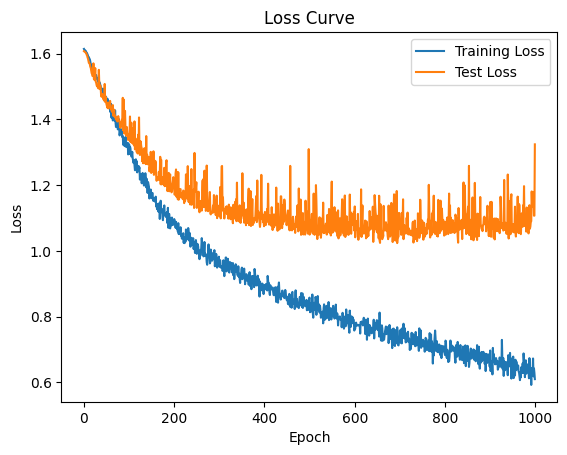

--------------------------------------------------
Test Accuracy: 66.12%
--------------------------------------------------


In [1185]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_3lay3 = EmotionCNN3layBS1(num_classes=num_classes)
best_model_bs1_3lay3.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_3lay3, test_loader_bs1, device=device)

The loss converges too slowly when the learning rate is set to 0.0001.

### 2.A.2 - *4 Layers*

In [1140]:
# CNN model with 4 layers
class EmotionCNN4layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [1141]:
model_bs1_4lay1 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_4lay1, train_loader_bs1, test_loader_bs1, 0.001, 100)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/100, Training Loss: 1.6052
Test Loss after Epoch 5: 1.5681
Test Accuracy after Epoch 5: 22.31%
--------------------------------------------------
Epoch 10/100, Training Loss: 1.2622
Test Loss after Epoch 10: 1.2769
Test Accuracy after Epoch 10: 44.63%
--------------------------------------------------
Epoch 15/100, Training Loss: 1.1351
Test Loss after Epoch 15: 1.3120
Test Accuracy after Epoch 15: 45.45%
--------------------------------------------------
Epoch 20/100, Training Loss: 1.0655
Test Loss after Epoch 20: 1.3397
Test Accuracy after Epoch 20: 51.24%
--------------------------------------------------
Epoch 25/100, Training Loss: 0.9531
Test Loss after Epoch 25: 1.1529
Test Accuracy after Epoch 25: 52.07%
--------------------------------------------------
Epoch 30/100, Training Loss: 0.8489
Test Loss after Epoch 30: 1.1012
Test Accuracy after Epoch 30: 63.64%
--------------------------------------------------
Epoch 35/100, Training Loss: 0.7605
Test Loss after Epoch 35:

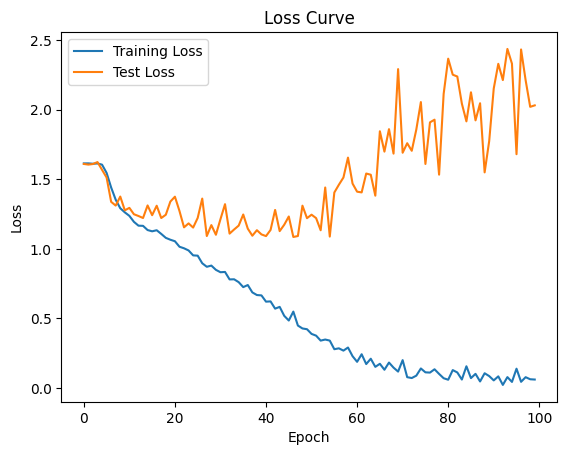

--------------------------------------------------
Test Accuracy: 71.90%
--------------------------------------------------


In [1142]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_4lay1 = EmotionCNN4layBS1(num_classes=num_classes)
best_model_bs1_4lay1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_4lay1, test_loader_bs1, device=device)

### Train with learning rate = 0.0001

In [1143]:
model_bs1_4lay2 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_4lay2, train_loader_bs1, test_loader_bs1, 0.0001, 250)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/250, Training Loss: 1.5941
Test Loss after Epoch 5: 1.5946
Test Accuracy after Epoch 5: 24.79%
--------------------------------------------------
Epoch 10/250, Training Loss: 1.4518
Test Loss after Epoch 10: 1.5132
Test Accuracy after Epoch 10: 33.88%
--------------------------------------------------
Epoch 15/250, Training Loss: 1.3540
Test Loss after Epoch 15: 1.4119
Test Accuracy after Epoch 15: 37.19%
--------------------------------------------------
Epoch 20/250, Training Loss: 1.2756
Test Loss after Epoch 20: 1.3822
Test Accuracy after Epoch 20: 42.98%
--------------------------------------------------
Epoch 25/250, Training Loss: 1.1983
Test Loss after Epoch 25: 1.3217
Test Accuracy after Epoch 25: 49.59%
--------------------------------------------------
Epoch 30/250, Training Loss: 1.1324
Test Loss after Epoch 30: 1.3224
Test Accuracy after Epoch 30: 45.45%
--------------------------------------------------
Epoch 35/250, Training Loss: 1.1247
Test Loss after Epoch 35:

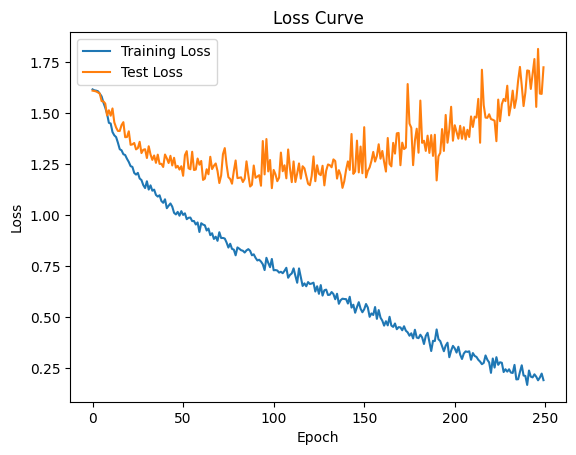

--------------------------------------------------
Test Accuracy: 67.77%
--------------------------------------------------


In [1144]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_4lay2 = EmotionCNN4layBS1(num_classes=num_classes)
best_model_bs1_4lay2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_4lay2, test_loader_bs1, device=device)

---

## 2.B - **CNNs with resized spectrograms**

We began by plotting the distribution of all $n$ values (number of time frames) across the Mel Spectrograms. This visualization helped us determine the optimal size to use for reshaping the spectrograms.

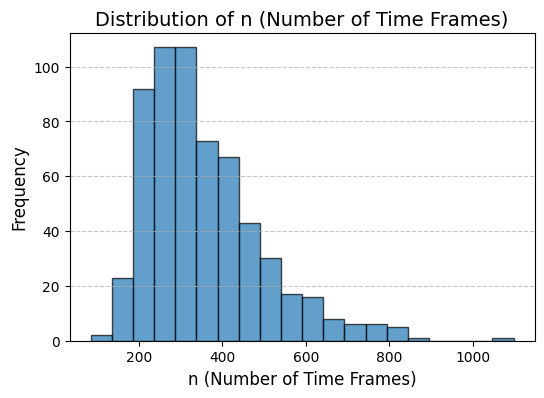

In [1183]:
n_values = [spec.shape[1] for spec in df_metadata['mel_spectrogram']]

#Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(n_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of n (Number of Time Frames)', fontsize=14)
plt.xlabel('n (Number of Time Frames)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2.B.1 - *Resize the Mel spectrogram to size $128\times256$ using padding and interpolation method*

In [1146]:
# Class to create a resized Mel Spectrogram dataset with tensors
class MelSpectrogramDatasetResized(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()
        mel_spectrogram = self._resize_mel_spectrogram(mel_spectrogram)
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor

    def _resize_mel_spectrogram(self, mel_spectrogram):

        target_size = 256

        # If spectrogram width is smaller than target, pad with zeros
        if mel_spectrogram.shape[1] < target_size:
            padding = target_size - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

        # If spectrogram width is larger than target, interpolate
        elif mel_spectrogram.shape[1] > target_size:
            mel_spectrogram = librosa.resample(
                mel_spectrogram,
                orig_sr=mel_spectrogram.shape[1],
                target_sr=target_size)

        return mel_spectrogram
    
# Create the datasets
train_dataset_resized = MelSpectrogramDatasetResized(train_df)
test_dataset_resized = MelSpectrogramDatasetResized(test_df)

### 2.B.2 - *3 layers CNN*

In [1147]:
# Create the data loaders with a batch size of 8
train_loader_res = DataLoader(train_dataset_resized, batch_size=8, shuffle=True)
test_loader_res = DataLoader(test_dataset_resized, batch_size=8, shuffle=False)

class EmotionCNN3lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(64 * 16 * 32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with lr = 0.001

In [1148]:
model_3lay_res1 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_3lay_res1, train_loader_res, test_loader_res, 0.001, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 1.2118
Test Loss after Epoch 5: 4.0352
Test Accuracy after Epoch 5: 44.63%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.3814
Test Loss after Epoch 10: 3.4412
Test Accuracy after Epoch 10: 52.07%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.2776
Test Loss after Epoch 15: 3.5215
Test Accuracy after Epoch 15: 47.11%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.2468
Test Loss after Epoch 20: 4.8395
Test Accuracy after Epoch 20: 47.93%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.0957
Test Loss after Epoch 25: 4.7720
Test Accuracy after Epoch 25: 42.98%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.0978
Test Loss after Epoch 30: 3.8759
Test Accuracy after Epoch 30: 54.55%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.0224
Test Loss after Epoch 35: 4.5205

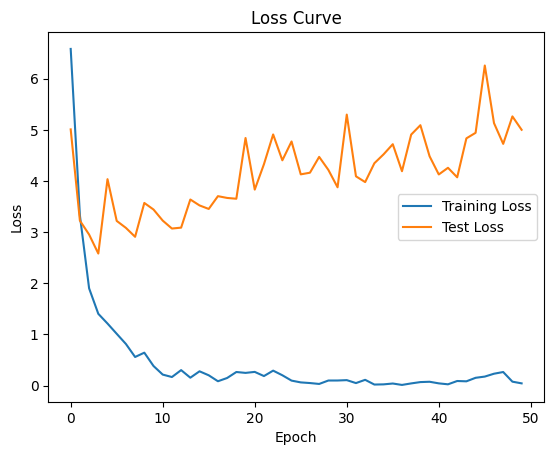

--------------------------------------------------
Test Accuracy: 55.37%
--------------------------------------------------


In [1149]:
plot_loss_curves(train_losses, test_losses)

best_model_3lay_res1 = EmotionCNN3lay_res(num_classes=num_classes)
best_model_3lay_res1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_3lay_res1, test_loader_res, device=device)

### Train with lr = 0.0001

In [1150]:
model_3lay_res2 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_3lay_res2, train_loader_res, test_loader_res, 0.01, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 0.4071
Test Loss after Epoch 5: 2.3386
Test Accuracy after Epoch 5: 47.11%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.1167
Test Loss after Epoch 10: 2.4932
Test Accuracy after Epoch 10: 52.07%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.0793
Test Loss after Epoch 15: 2.9446
Test Accuracy after Epoch 15: 45.45%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.0956
Test Loss after Epoch 20: 3.6529
Test Accuracy after Epoch 20: 47.11%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.1354
Test Loss after Epoch 25: 3.8969
Test Accuracy after Epoch 25: 47.11%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.1742
Test Loss after Epoch 30: 4.6584
Test Accuracy after Epoch 30: 53.72%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.0545
Test Loss after Epoch 35: 4.9514

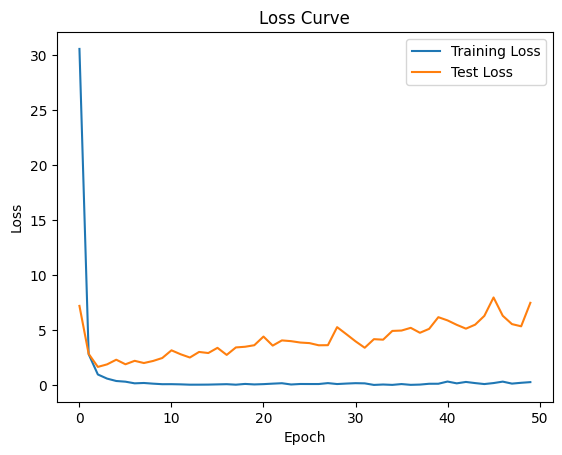

--------------------------------------------------
Test Accuracy: 53.72%
--------------------------------------------------


In [1151]:
plot_loss_curves(train_losses, test_losses)

best_model_3lay_res2 = EmotionCNN3lay_res(num_classes=num_classes)
best_model_3lay_res2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_3lay_res2, test_loader_res, device=device)

### 2.B.3 - *4 layers CNN*

In [1154]:
class EmotionCNN4lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)  # Adjust based on final output shape of conv layers

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x



### Train with learning rate = 0.001

In [1174]:
model_4lay_res1 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_4lay_res1, train_loader_res, test_loader_res, 0.001, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 0.9154
Test Loss after Epoch 5: 2.2612
Test Accuracy after Epoch 5: 48.76%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.4025
Test Loss after Epoch 10: 2.1806
Test Accuracy after Epoch 10: 50.41%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.4154
Test Loss after Epoch 15: 2.1508
Test Accuracy after Epoch 15: 55.37%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.1289
Test Loss after Epoch 20: 2.2899
Test Accuracy after Epoch 20: 54.55%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.0453
Test Loss after Epoch 25: 2.5602
Test Accuracy after Epoch 25: 56.20%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.2064
Test Loss after Epoch 30: 3.3867
Test Accuracy after Epoch 30: 51.24%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.1779
Test Loss after Epoch 35: 3.1431

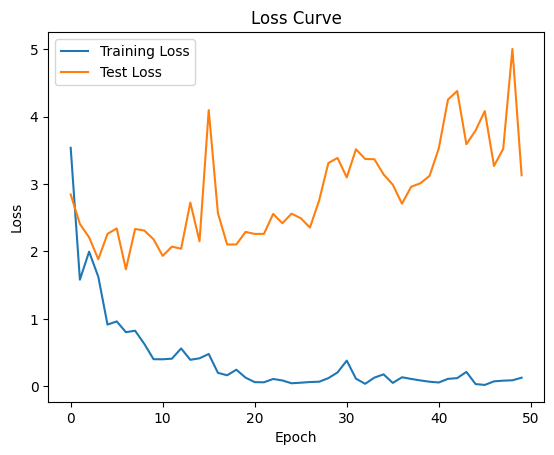

--------------------------------------------------
Test Accuracy: 61.98%
--------------------------------------------------


In [1175]:
plot_loss_curves(train_losses, test_losses)

best_model_4lay_res1 = EmotionCNN4lay_res(num_classes=num_classes)
best_model_4lay_res1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_4lay_res1, test_loader_res, device=device)

### Train with learning rate = 0.0001

In [1172]:
model_4lay_res2 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_4lay_res2, train_loader_res, test_loader_res, 0.0001, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 0.7217
Test Loss after Epoch 5: 1.4782
Test Accuracy after Epoch 5: 40.50%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.2585
Test Loss after Epoch 10: 1.3762
Test Accuracy after Epoch 10: 53.72%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.1112
Test Loss after Epoch 15: 1.3673
Test Accuracy after Epoch 15: 56.20%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.0635
Test Loss after Epoch 20: 1.3958
Test Accuracy after Epoch 20: 54.55%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.0406
Test Loss after Epoch 25: 1.3434
Test Accuracy after Epoch 25: 57.02%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.0281
Test Loss after Epoch 30: 1.3196
Test Accuracy after Epoch 30: 57.85%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.0149
Test Loss after Epoch 35: 1.3552

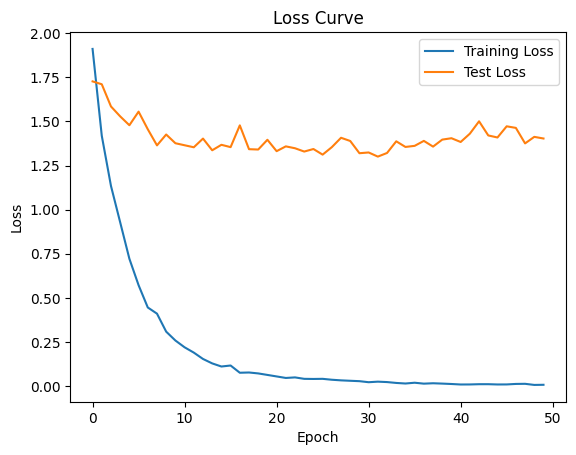

--------------------------------------------------
Test Accuracy: 62.81%
--------------------------------------------------


In [1173]:
plot_loss_curves(train_losses, test_losses)

best_model_4lay_res2 = EmotionCNN4lay_res(num_classes=num_classes)
best_model_4lay_res2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_4lay_res2, test_loader_res, device=device)

---

## 2.C - **CNNs on artificial data**

### 2.C.1 - *Data augmentation techniques*

We create 4 fonctions that can modify our Mel spectrograms to create new data.

In [1159]:
import random

# Function to add noise to the spectrogram
def add_noise(spectrogram, noise_level=0.01):
    noise = np.random.normal(0, noise_level, spectrogram.shape)
    return spectrogram + noise

# Function to shift the pitch of the spectrogram
def pitch_shift(spectrogram, sr, n_steps):
    return librosa.effects.pitch_shift(spectrogram, sr=sr, n_steps=n_steps)

# Function to apply a frequency mask
def freq_mask(spectrogram, freq_mask_param):
    spec = spectrogram.copy()
    f = random.randint(0, freq_mask_param)
    f0 = random.randint(0, spec.shape[0] - f)
    spec[f0:f0 + f, :] = 0
    return spec

# Function to apply a time mask
def time_mask(spectrogram, time_mask_param):
    spec = spectrogram.copy()
    t = random.randint(0, time_mask_param)
    t0 = random.randint(0, spec.shape[1] - t)
    spec[:, t0:t0 + t] = 0
    return spec

# We apply the functions on the train set
augmented_data = []

for spec in train_df['mel_spectrogram']:

    for i in range(10):

        augmented = spec.copy()
        
        # Apply random transformations
        if random.random() < 0.6:
            augmented = add_noise(augmented)
        if random.random() < 0.6:
            n_steps = random.uniform(-4, 4)
            augmented = librosa.db_to_power(augmented)
            augmented = pitch_shift(augmented, sr, n_steps)
            augmented = librosa.power_to_db(augmented)
        if random.random() < 0.6:
            freq_mask_param = random.randint(10, 30)
            augmented = freq_mask(augmented, freq_mask_param)
        if random.random() < 0.6:
            time_mask_param = random.randint(10, 50)
            augmented = time_mask(augmented, time_mask_param)

        augmented_data.append(augmented)

We create a dataset with the augmented_data and the correponding label and convert them to tensor.

In [1160]:
augmented_emotion = train_df['emotion'].values.repeat(10)

train_df_augmented = pd.DataFrame({
    'mel_spectrogram': augmented_data,
    'emotion': augmented_emotion
})

train_df_augmented['emotion_encoded'] = label_encoder.transform(train_df_augmented['emotion'])
train_dataset_augmented = MelSpectrogramDataset(train_df_augmented)
train_loader_augmented_bs1 = DataLoader(train_dataset_augmented, batch_size=1, shuffle=True)


Check for duplicates in the 'mel_spectrogram' column of train_df_augmented

In [1186]:
# Identify duplicate rows based on the 'mel_spectrogram' column
duplicates = train_df_augmented[train_df_augmented.duplicated(subset='mel_spectrogram', keep=False)]

# Display duplicate rows
print("Duplicate rows in 'mel_spectrogram' column:")
print(duplicates)

Duplicate rows in 'mel_spectrogram' column:
Empty DataFrame
Columns: [mel_spectrogram, emotion, emotion_encoded]
Index: []


### 2.C.2 - *CNN with batch size of 1*

We only do 4 layers because it converges faster and computation are slow.

### Training with learnig rate = 0.001

In [1161]:
model_bs1_4lay_aug1 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_4lay_aug1, train_loader_augmented_bs1, test_loader_bs1, 0.001, 100)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/100, Training Loss: 1.1130
Test Loss after Epoch 5: 1.3768
Test Accuracy after Epoch 5: 53.72%
--------------------------------------------------
Epoch 10/100, Training Loss: 0.6014
Test Loss after Epoch 10: 2.0733
Test Accuracy after Epoch 10: 54.55%
--------------------------------------------------
Epoch 15/100, Training Loss: 0.2747
Test Loss after Epoch 15: 2.3909
Test Accuracy after Epoch 15: 58.68%
--------------------------------------------------
Epoch 20/100, Training Loss: 0.1489
Test Loss after Epoch 20: 3.6216
Test Accuracy after Epoch 20: 55.37%
--------------------------------------------------
Epoch 25/100, Training Loss: 0.1169
Test Loss after Epoch 25: 4.6663
Test Accuracy after Epoch 25: 57.02%
--------------------------------------------------
Epoch 30/100, Training Loss: 0.1021
Test Loss after Epoch 30: 3.4934
Test Accuracy after Epoch 30: 58.68%
--------------------------------------------------
Epoch 35/100, Training Loss: 0.0808
Test Loss after Epoch 35:

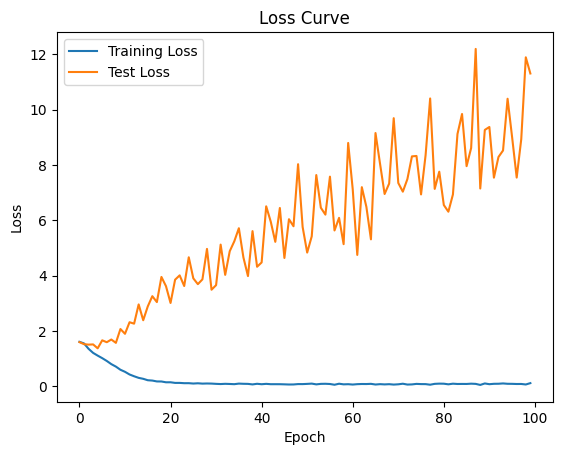

--------------------------------------------------
Test Accuracy: 66.94%
--------------------------------------------------


In [1162]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_4lay_aug1 = EmotionCNN4layBS1(num_classes=num_classes)
best_model_bs1_4lay_aug1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_4lay_aug1, test_loader_bs1, device=device)

### Training with learnig rate = 0.0001

In [1163]:
model_bs1_4lay_aug2 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_bs1_4lay_aug2, train_loader_augmented_bs1, test_loader_bs1, 0.0001, 100)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/100, Training Loss: 1.3633
Test Loss after Epoch 5: 1.4230
Test Accuracy after Epoch 5: 38.02%
--------------------------------------------------
Epoch 10/100, Training Loss: 1.1407
Test Loss after Epoch 10: 1.3253
Test Accuracy after Epoch 10: 47.11%
--------------------------------------------------
Epoch 15/100, Training Loss: 1.0267
Test Loss after Epoch 15: 1.3414
Test Accuracy after Epoch 15: 52.07%
--------------------------------------------------
Epoch 20/100, Training Loss: 0.9423
Test Loss after Epoch 20: 1.4500
Test Accuracy after Epoch 20: 51.24%
--------------------------------------------------
Epoch 25/100, Training Loss: 0.8623
Test Loss after Epoch 25: 1.3446
Test Accuracy after Epoch 25: 57.02%
--------------------------------------------------
Epoch 30/100, Training Loss: 0.7801
Test Loss after Epoch 30: 1.3576
Test Accuracy after Epoch 30: 58.68%
--------------------------------------------------
Epoch 35/100, Training Loss: 0.6838
Test Loss after Epoch 35:

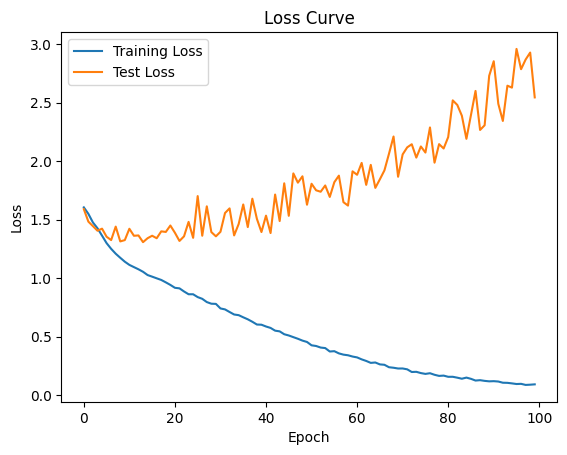

--------------------------------------------------
Test Accuracy: 70.25%
--------------------------------------------------


In [1164]:
plot_loss_curves(train_losses, test_losses)

best_model_bs1_4lay_aug2 = EmotionCNN4layBS1(num_classes=num_classes)
best_model_bs1_4lay_aug2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_bs1_4lay_aug2, test_loader_bs1, device=device)

### 2.C.3 - *CNN with resized data*

In [1176]:
train_dataset_augmented_resized = MelSpectrogramDatasetResized(train_df_augmented)
train_loader_augmented_res = DataLoader(train_dataset_augmented_resized, batch_size=16, shuffle=True)

class EmotionCNN4lay_res_aug(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res_aug, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [1177]:
model_4lay_res_aug1 = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_4lay_res_aug1, train_loader_augmented_res, test_loader_res, 0.001, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 0.6307
Test Loss after Epoch 5: 2.9226
Test Accuracy after Epoch 5: 42.98%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.1826
Test Loss after Epoch 10: 2.7253
Test Accuracy after Epoch 10: 57.85%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.0827
Test Loss after Epoch 15: 4.1422
Test Accuracy after Epoch 15: 55.37%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.0695
Test Loss after Epoch 20: 3.2908
Test Accuracy after Epoch 20: 58.68%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.0441
Test Loss after Epoch 25: 3.5529
Test Accuracy after Epoch 25: 57.85%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.0315
Test Loss after Epoch 30: 4.6328
Test Accuracy after Epoch 30: 57.02%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.0264
Test Loss after Epoch 35: 3.7900

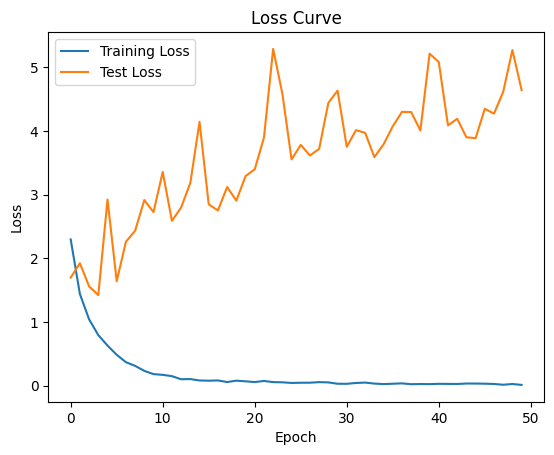

--------------------------------------------------
Test Accuracy: 62.81%
--------------------------------------------------


In [1178]:
plot_loss_curves(train_losses, test_losses)

best_model_4lay_res_aug1 = EmotionCNN4lay_res_aug(num_classes=num_classes)
best_model_4lay_res_aug1.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_4lay_res_aug1, test_loader_res, device=device)

### Train with learning rate = 0.0001

In [1179]:
model_4lay_res_aug2 = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses, test_losses, best_info = train_model(model_4lay_res_aug2, train_loader_augmented_res, test_loader_res, 0.0001, 50)
print("Best Epoch:", best_info["Best epoch"])
print("Best Test Accuracy:", best_info["Best test accuracy"])

Epoch 5/50, Training Loss: 0.5103
Test Loss after Epoch 5: 1.4032
Test Accuracy after Epoch 5: 48.76%
--------------------------------------------------
Epoch 10/50, Training Loss: 0.1822
Test Loss after Epoch 10: 1.4466
Test Accuracy after Epoch 10: 56.20%
--------------------------------------------------
Epoch 15/50, Training Loss: 0.0949
Test Loss after Epoch 15: 1.6593
Test Accuracy after Epoch 15: 49.59%
--------------------------------------------------
Epoch 20/50, Training Loss: 0.0594
Test Loss after Epoch 20: 1.8607
Test Accuracy after Epoch 20: 54.55%
--------------------------------------------------
Epoch 25/50, Training Loss: 0.0628
Test Loss after Epoch 25: 1.8076
Test Accuracy after Epoch 25: 54.55%
--------------------------------------------------
Epoch 30/50, Training Loss: 0.0347
Test Loss after Epoch 30: 1.8386
Test Accuracy after Epoch 30: 54.55%
--------------------------------------------------
Epoch 35/50, Training Loss: 0.0342
Test Loss after Epoch 35: 2.1431

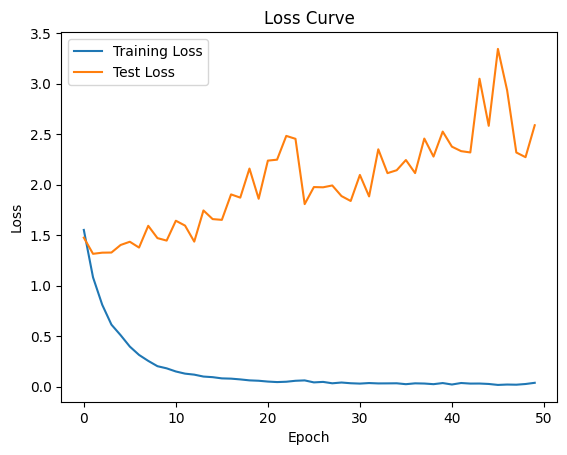

--------------------------------------------------
Test Accuracy: 59.50%
--------------------------------------------------


In [1180]:
plot_loss_curves(train_losses, test_losses)

best_model_4lay_res_aug2 = EmotionCNN4lay_res_aug(num_classes=num_classes)
best_model_4lay_res_aug2.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model_4lay_res_aug2, test_loader_res, device=device)

---
---